# **Ant Colony Optimization with Reinforcement Learning**
## Daniel Escobar & Noah van Potten
### ELTE univesity Budapest, 2025 Fall semseter, computational intelligence


This project explores the fascinating world of Reinforcement Learning (RL) by training a simulated ant agent to perform complex environmental tasks. The core objective is to develop an RL model that enables an "ant" to intelligently interact with a grid-based environment, specifically focusing on two primary behaviors:

1.  **Clustering**: The ant learns to collect and group similar colored items together on the grid.
2.  **Sorting**: Extending the clustering task, the ant learns to not only group items but also to sort different colored items into distinct, separate clusters.


# **Initial imports and Configuration**


## **Cell explanations**
This project begins by importing several essential Python libraries and defining a `Config` class to centralize crucial simulation and reinforcement learning hyperparameters.

#### **Imports**

`torch` / `torch.nn` / `torch.nn.functional` / `torch.optim` / `torch.distributions.Categorical` - Pytorch for working with neural nets and optimalization problems

`numpy` – Fast numerical array operations for the grid.

`random` – Simple random number utilities for initialization.

`matplotlib.pyplot` – Used to plot rewards and training curves.

`clear_output` – Refreshes the training plots in real time.

#### **Config class**
Stores all global environment and RL hyperparameters (grid size, colors, learning rate, model size, episodes, action space, device).

In [226]:
# Torch imports
import torch # Full torch import
# Specific torch imports for easier accesibilty
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Other imports
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

# --- CONFIGURATION ---
class Config:
    GRID_WIDTH = 20
    GRID_HEIGHT = 20
    NUM_COLORS = 2
    FILL_PERCENTAGE = 0.3
    NUM_ANTS = 5

    # Rule based variables
    K1_RULE_BASED = 0.1
    K2_RULE_BASED = 0.3
    MAX_STEPS = 2000

    # RL variables
    RL_LEARNING_RATE = 2e-4  # Lower learning rate for more stable training
    RL_HIDDEN_SIZE = 128
    RL_NUM_EPISODES = 1000
    RL_STEPS_PER_EPISODE = 5000  # Longer episodes for better learning
    RL_EVAL_FREQUENCY = 5  # Evaluate every N episodes
    RL_GAMMA = 0.8  # Higher discount factor for long-term planning
    RL_LR_STEP_SIZE = 1000  # Learning rate scheduler step size
    RL_LR_GAMMA = 0.5  # Learning rate scheduler decay factor
    ACTION_SPACE_SIZE = 7 # Up, Down, Left, Right, Pick, Drop, Stay
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

cfg = Config()

# **Grid and Ant Definitions**

## **Cell explanations**
## 1. `Ant` Class
- Represents the agent on the grid.  
- Stores its position (`x`, `y`) and whether it's carrying an item (`carrying`).

## 2. `Grid` Class
- Represents the 2D environment of items.  
- Contains the grid array (`cells`), size (`width`, `height`), and number of colors.

### Key Methods
- **`_populate()`** – Randomly fills the grid with items.  
- **`move_ant()`** – Moves the ant if within bounds.  
- **`pick_item()`** – Ant picks up an item from its cell.  
- **`drop_item()`** – Ant drops its carried item onto an empty cell.

## 3. `calculate_clustering_score`
- Computes how well similar-colored items cluster together.  
- Checks neighboring cells for same-color pairs and normalizes by total item count.


In [227]:
# --- ANT (Base Class) ---
class Ant:
    def __init__(self, x, y):
        self.x = x # current X position of the ant
        self.y = y # current Y position of the ant
        self.carrying = None  # None or color_id (int)

In [228]:
# --- GRID (Base Class) ---
class Grid:
    def __init__(self, width, height, num_colors, fill_percentage=0.4):
        self.width = width
        self.height = height
        self.cells = np.zeros((height, width), dtype=int) # Empty grid with the width and height
        self.num_colors = num_colors
        self._populate(fill_percentage) # Populate the empty grid

    # Simple get function for a cell
    def get(self, x, y):
        return self.cells[y, x]

    # Populate the grid with a certain fill percentage
    def _populate(self, fill_percentage):
        for y in range(self.height):
            for x in range(self.width):
                if random.random() < fill_percentage:
                    self.cells[y, x] = random.randint(1, self.num_colors)

    # Move an ant if its possible givign the grid width and height
    def move_ant(self, ant, dx, dy):
        nx, ny = ant.x + dx, ant.y + dy
        if 0 <= nx < self.width and 0 <= ny < self.height:
            ant.x, ant.y = nx, ny
            return True
        return False

    # Let an ant pick up an item if possible
    def pick_item(self, ant):
        # Can only pick if: Cell has item AND Ant hands are empty
        if self.cells[ant.y, ant.x] != 0 and ant.carrying is None:
            ant.carrying = self.cells[ant.y, ant.x]
            self.cells[ant.y, ant.x] = 0
            return True
        return False

    # Let and ant drop an item if possible
    def drop_item(self, ant):
        # Can only drop if: Cell is empty AND Ant has item
        if self.cells[ant.y, ant.x] == 0 and ant.carrying is not None:
            self.cells[ant.y, ant.x] = ant.carrying
            ant.carrying = None
            return True
        return False

    # Get the similairty of a value and the neigbourhood of one coordinate
    def get_local_similarity(self, x, y, value, radius=1):
      count_same = 0
      count_total = 0
      for dx in range(-radius, radius + 1):
          for dy in range(-radius, radius + 1):
              if dx == 0 and dy == 0:
                  continue  # skip center cell
              nx = x + dx
              ny = y + dy
              # Bounds check
              if 0 <= nx < self.width and 0 <= ny < self.height:
                  neighbor_val = self.get(nx, ny)
                  if neighbor_val != 0:
                      count_total += 1
                      if neighbor_val == value:
                          count_same += 1
      if count_total == 0:
          return 0
      return count_same / count_total


In [229]:
# Calculate how well the items are clustered on a given grid
def calculate_clustering_score(grid):
    # Sum of adjacent matching pairs / Total Pairs
    # This provides the Global Reward signal.
    score = 0
    h, w = grid.cells.shape
    total_items = 0

    for y in range(h):
        for x in range(w):
            val = grid.cells[y, x]
            if val == 0: continue
            total_items += 1

            # Check right
            if x + 1 < w and grid.cells[y, x+1] == val:
                score += 1
            # Check down
            if y + 1 < h and grid.cells[y+1, x] == val:
                score += 1

    if total_items == 0: return 0.0

    # Normalize by total items to keep reward magnitude consistent
    # regardless of how full the grid is.
    return score / total_items

# **Rule-Based Ant Implementation**



## **Cell explanations**
The rule-based ant is a simple agent that follows classical behavior rules from ant clustering algorithms. It extends the base `Ant` class by adding interaction with the grid and probabilistic pick/drop decisions.

### Key Behaviors
- **Pick rule:** If the ant is empty-handed and stands on an item, it may pick it up. The probability decreases when many similar items are nearby.
- **Drop rule:** If the ant is carrying an item and stands on an empty cell, it may drop it. The probability increases when many similar items are nearby.
- **Movement:** The ant randomly moves to any valid neighboring cell (8-direction movement).

This baseline creates emergent clustering patterns without learning and is used as a comparison against the reinforcement-learning ant.


In [230]:
# --- RULE-BASED ANT (extends Ant) ---
class RuleBasedAnt(Ant):
    DIRECTIONS = [
        (-1,-1), (-1,0), (-1,1),
        (0,-1),          (0,1),
        (1,-1),  (1,0),  (1,1)
    ] # possible movement directions

    def __init__(self, grid, k1, k2, start_x=None, start_y=None):
        # Initialize base Ant with coordinates
        x = start_x if start_x is not None else random.randint(0, grid.width - 1)
        y = start_y if start_y is not None else random.randint(0, grid.height - 1)
        super().__init__(x, y)

        self.grid = grid
        self.k1 = k1
        self.k2 = k2

    # One time step for the ant
    def step(self):
        cell_value = self.grid.get(self.x, self.y)
        self._pickup_rule(cell_value)
        self._drop_rule(cell_value)
        self._random_movement()

    # Implementation of the pick rule
    def _pickup_rule(self, cell_value):
        # Can only pick up if hands are empty AND cell has an item
        if self.carrying is None and cell_value != 0:
            sim = self.grid.get_local_similarity(self.x, self.y, cell_value)  # compute similarity locally
            pick_prob = (self.k1 / (self.k1 + sim)) ** 2

            # Pick item stochastically based on similarity
            if random.random() < pick_prob:
                self.carrying = cell_value
                self.grid.cells[self.y, self.x] = 0  # remove item from grid

    # Implementation of the drop rule
    def _drop_rule(self, cell_value):
        # Can only drop if carrying an item AND current cell is empty
        if self.carrying is not None and cell_value == 0:
            sim = self.grid.get_local_similarity(self.x, self.y, self.carrying)
            drop_prob = (sim / (self.k2 + sim)) ** 2

            # Drop item stochastically based on similarity
            if random.random() < drop_prob:
                self.grid.cells[self.y, self.x] = self.carrying
                self.carrying = None

    # Choose a random move from the possible moves
    def _random_movement(self):
        valid_moves = []
        # Check all possible movement directions
        for dx, dy in self.DIRECTIONS:
            nx = self.x + dx
            ny = self.y + dy
            # Check whether the next position is inside the grid boundaries
            if 0 <= nx < self.grid.width and 0 <= ny < self.grid.height:
                valid_moves.append((dx, dy))
        # Perform a random valid movement
        if valid_moves:
            dx, dy = random.choice(valid_moves)
            self.x += dx
            self.y += dy



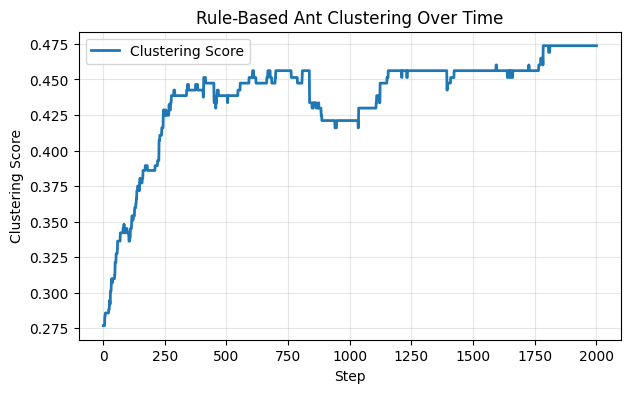

In [231]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# --- Initialize Grid and Ants ---
grid = Grid(cfg.GRID_WIDTH, cfg.GRID_HEIGHT, cfg.NUM_COLORS, cfg.FILL_PERCENTAGE)

ants = []
for i in range(cfg.NUM_ANTS):
    ants.append(RuleBasedAnt(grid, cfg.K1_RULE_BASED, cfg.K2_RULE_BASED))


# --- For plotting ---
scores = []
steps = []

plt.ion()  # interactive mode ON

for step in range(1, cfg.MAX_STEPS + 1):
    # Step all ants
    for ant in ants:
        ant.step()

    # Compute clustering score
    score = calculate_clustering_score(grid)
    scores.append(score)
    steps.append(step)

    # --- Live plot ---
    if step % 100 == 0:   # update every 100 steps so it doesn't flicker too fast
        clear_output(wait=True)
        plt.figure(figsize=(7,4))
        plt.plot(steps, scores, label="Clustering Score", linewidth=2)
        plt.title("Rule-Based Ant Clustering Over Time")
        plt.xlabel("Step")
        plt.ylabel("Clustering Score")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        plt.pause(0.001)

plt.ioff()
